In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [3]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, 
                score_func=None, n_folds=5, n_jobs=1):
    subdf = indf[featurenames]
    X = subdf.values
    y = (indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold,
                alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

# setting up data

In [7]:
df_hw=pd.read_csv("D:\\Machine Learning\\01_heights_weights_genders.csv")
print df_hw.shape
df_hw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


We sample 500 points from 10,000, since we actually want to see trends clearly on the plots

In [8]:
df=df_hw.sample(500, replace=False)
np.sum(df.Gender=="Male")

238

In [9]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([ True,  True,  True, False, False, False,  True, False,  True, False], dtype=bool)

C:\Users\NIHIT\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'C': 0.001} 0.943333333333 [mean: 0.94333, std: 0.03361, params: {'C': 0.001}, mean: 0.94333, std: 0.02864, params: {'C': 0.01}, mean: 0.94333, std: 0.02864, params: {'C': 0.1}, mean: 0.94000, std: 0.02669, params: {'C': 1}, mean: 0.94000, std: 0.02669, params: {'C': 10}, mean: 0.94333, std: 0.02669, params: {'C': 100}, mean: 0.94000, std: 0.02681, params: {'C': 1000}, mean: 0.94000, std: 0.02681, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.92
[[96  9]
 [ 8 87]]
########################################################


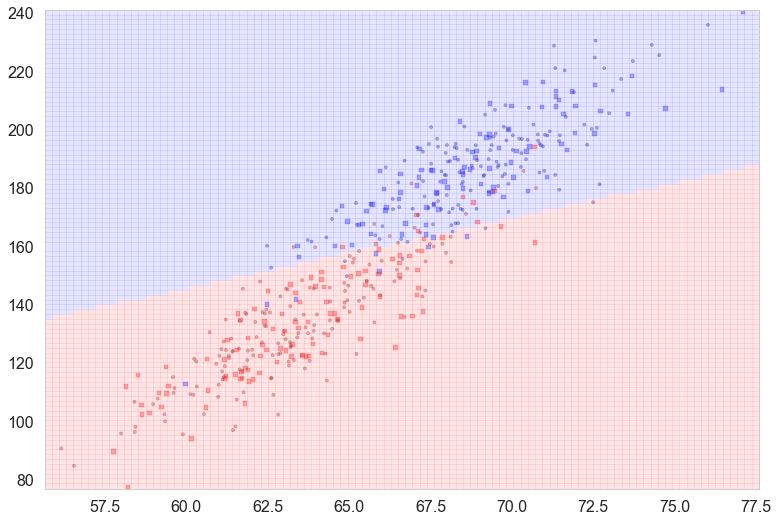

In [10]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [11]:
clflog.predict(Xtest)

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1])

In [14]:
clflog.predict_proba(Xtest)[:,1]

array([ 0.46701278,  0.95799373,  0.09244865,  0.04295073,  0.96591526,
        0.78261994,  0.15154104,  0.84351976,  0.88152588,  0.61470226,
        0.49150603,  0.84752645,  0.31150857,  0.56288144,  0.04941441,
        0.59340639,  0.93270958,  0.70969159,  0.13793788,  0.58554086,
        0.06169264,  0.79533557,  0.63509335,  0.19393456,  0.71607784,
        0.77600602,  0.03249867,  0.83265101,  0.41415256,  0.96855684,
        0.68089055,  0.27385232,  0.56569215,  0.96171646,  0.87551501,
        0.6772102 ,  0.09199356,  0.85014405,  0.39470385,  0.05897496,
        0.00431489,  0.05417597,  0.672404  ,  0.10270616,  0.02372354,
        0.88487344,  0.9544488 ,  0.16279024,  0.13681432,  0.04292774,
        0.02694046,  0.01347891,  0.74107901,  0.3270788 ,  0.06116024,
        0.71367721,  0.1923736 ,  0.10339352,  0.26935266,  0.06405333,
        0.86981206,  0.72034584,  0.09844229,  0.72867117,  0.91399878,
        0.85099871,  0.04876112,  0.69301153,  0.87067107,  0.90

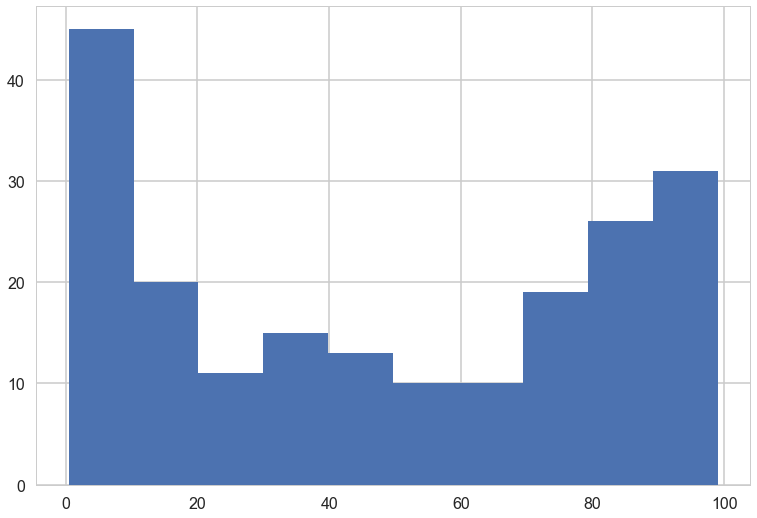

In [15]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

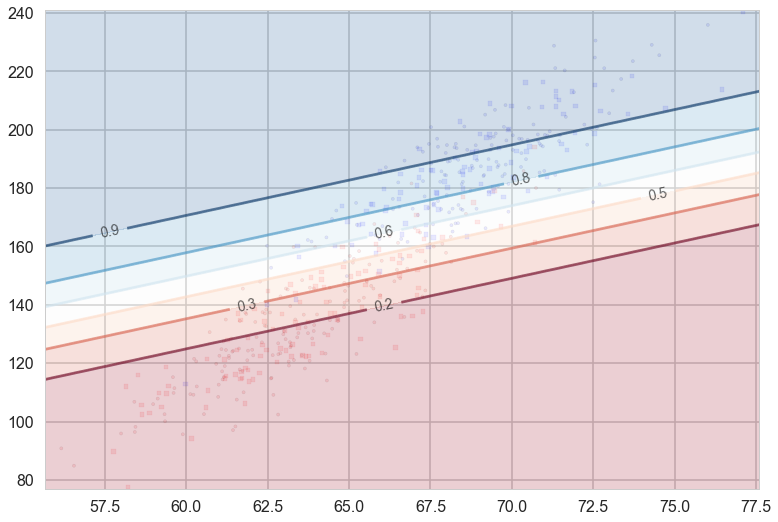

In [16]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [17]:
clflog.score(Xtest, ytest)

0.91500000000000004

# SVM is discriminant classifier..It is not probabilistic

C:\Users\NIHIT\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'C': 1000} 0.95 [mean: 0.93667, std: 0.02423, params: {'C': 0.001}, mean: 0.93667, std: 0.02831, params: {'C': 0.01}, mean: 0.94333, std: 0.02245, params: {'C': 0.1}, mean: 0.94333, std: 0.02245, params: {'C': 1}, mean: 0.94333, std: 0.02245, params: {'C': 10}, mean: 0.94667, std: 0.02196, params: {'C': 100}, mean: 0.95000, std: 0.02731, params: {'C': 1000}]
############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.92
[[96  9]
 [ 8 87]]
########################################################


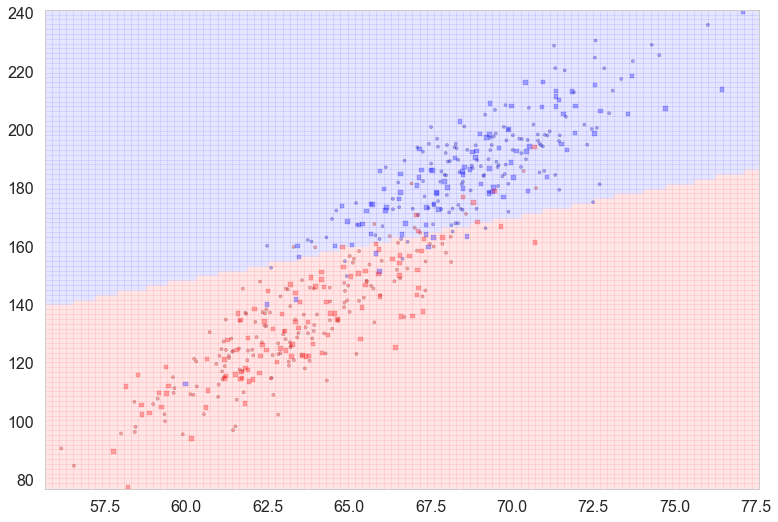

In [18]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [19]:
clfsvm.decision_function(Xtest)

array([ -1.53824217,  29.47352636, -23.15726032, -31.84326302,
        31.33212743,  11.39065939, -17.76027613,  15.66749701,
        19.23635019,   3.29677439,  -1.3804497 ,  15.15840532,
        -8.88926787,   1.47285803, -29.82363578,   2.80500737,
        25.14343215,   7.67440025, -18.61135704,   1.92612079,
       -28.07032487,  11.69793625,   4.33554764, -14.25499598,
         8.38587682,  11.30760823, -34.52523111,  14.32180838,
        -4.06428928,  32.64519453,   6.46809693, -10.78363831,
         1.26521818,  29.8691535 ,  17.68544154,   6.52816773,
       -23.6355862 ,  15.84473312,  -5.5229891 , -28.0612805 ,
       -53.98503605, -29.01448748,   6.50959722, -22.59642239,
       -36.98091731,  18.45424039,  28.76223954, -16.78870335,
       -18.94709774, -31.17152027, -35.99567411, -43.24093536,
         9.58592065,  -8.26621425, -27.19079862,   8.25103405,
       -15.31885312, -21.30335606, -10.56186915, -26.84602333,
        18.01266736,   8.59713099, -21.74752216,   8.06

We can plt a histogram. In terms of distance from the separator, we can see that most samples on either side are a middling distance away. This is different from the probability diagram

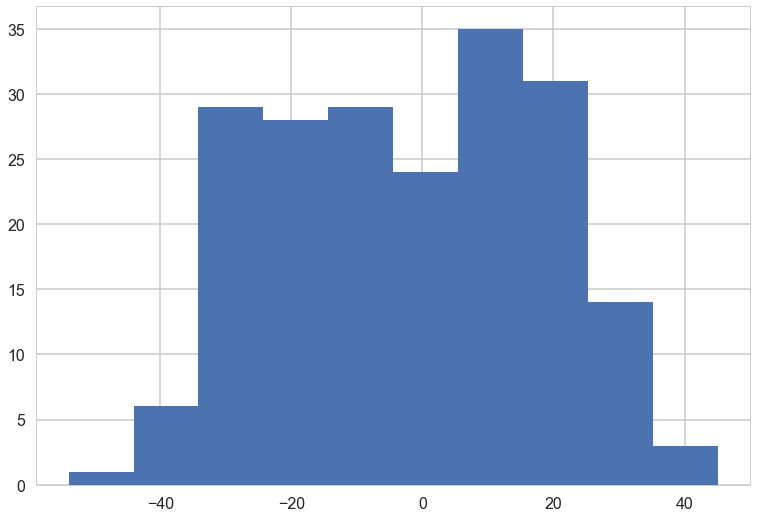

In [20]:
plt.hist(clfsvm.decision_function(Xtest));

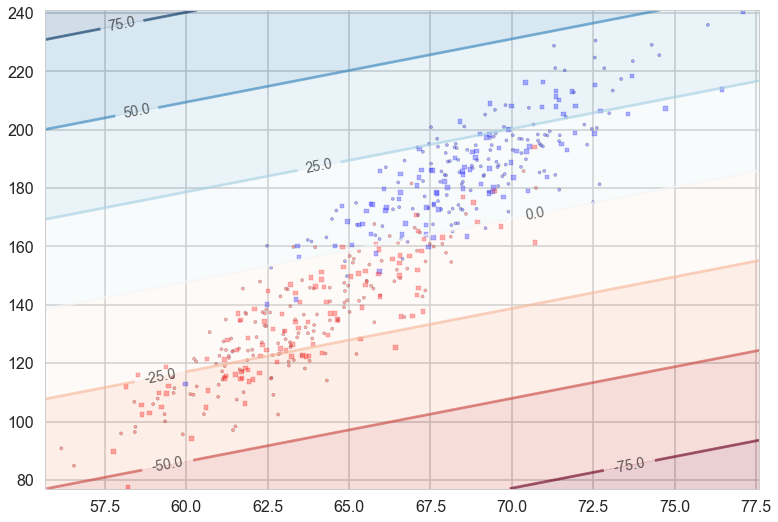

In [21]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

The decision function can be used to plot the margins of the SVM.

In [22]:
#From Jake Vanderplas's ESAC notebook
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

C:\Users\NIHIT\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\NIHIT\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\NIHIT\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarn

(125, 225)

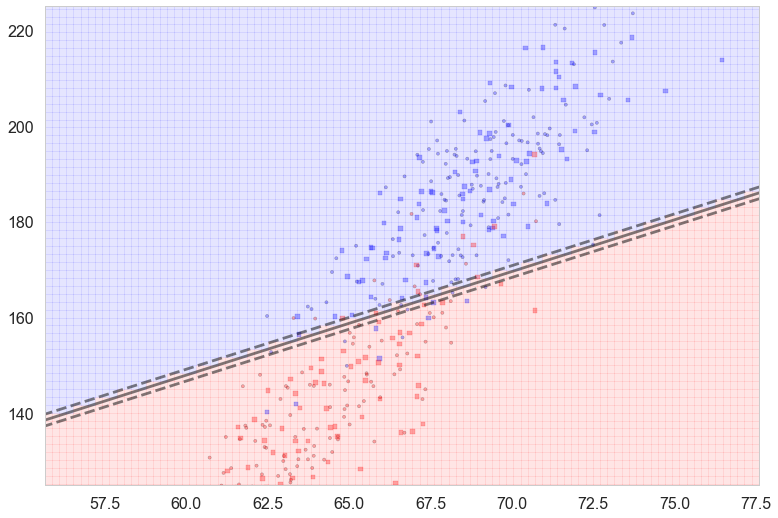

In [23]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

MPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed y first, i.e.: use as confusion_matrix(y_true, y_pred)

In [24]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[96,  9],
       [ 8, 87]])

In [25]:
from sklearn.metrics import classification_report
print classification_report(ytest, clflog.predict(Xtest))

             precision    recall  f1-score   support

          0       0.92      0.91      0.92       105
          1       0.91      0.92      0.91        95

avg / total       0.92      0.92      0.92       200



# The cancer doctor

Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

In [27]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[42, 63],
       [ 1, 94]])

In [28]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

We plot ROC curves for both our classifiers:

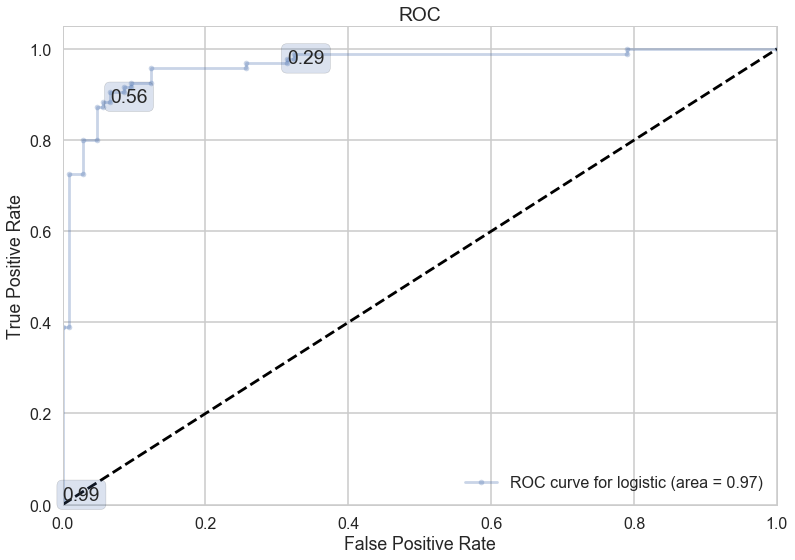

In [29]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

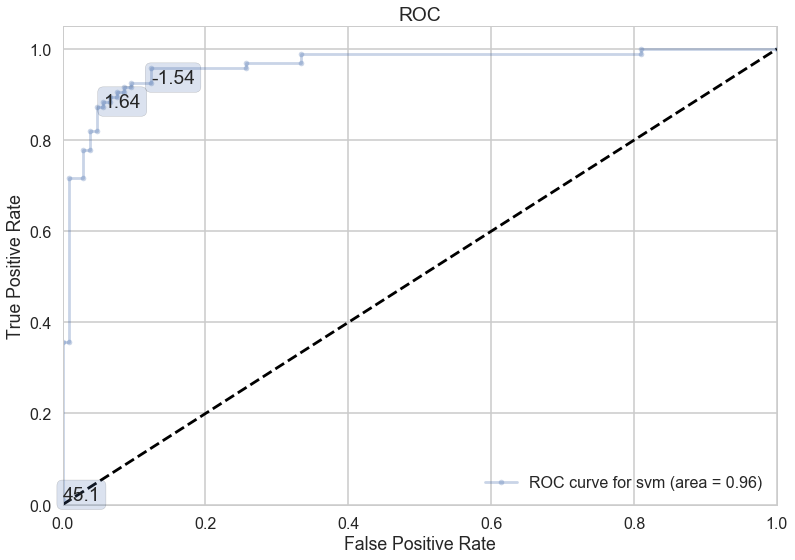

In [30]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)